**Modelo de red neuronal CNN**

Este archivo consta de los codigos de:
* 1.Carga de librerias y datos
* 2.Proceso de entrenamiento
  * 2.1. Separacion de datos en train y test
  * 2.2 Modelo CNN
* 3.Evaluacion del modelo
* 4.Exportar resultados


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

##Carga de librerias

In [ ]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, Dense, Activation,Input
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit

In [ ]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:

cd /content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico

/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico


##Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv' ,index_col='dt')
target_variables=pd.read_csv('target_variables.csv' ,index_col='dt')

In [ ]:
#Setear semilla
np.random.seed(42)

#2.Proceso de entrenamiento

**Se establece los parametros de:**

In [ ]:
#Se establece porcentaje de usado para test
PORCENTAJE_TEST=0.2

#Se define la cantidad de intentos de la optimizacion bayesiana
INTENTOS=100


##2.1. Separacion de data en train y test

In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=PORCENTAJE_TEST, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


##2.2. Modelo CNN

In [ ]:
import time
#Setear semilla
#Ajustar parámetros para reproducibilidad del entrenamiento
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],Y_train_s.shape[1],1))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1],1))

In [ ]:
print(X_train.shape)
print(Y_train_s.shape)
print(X_test.shape)
print(Y_test.shape)

(1138, 21, 1)
(1138, 1, 1)
(285, 21, 1)
(285, 1, 1)


In [ ]:
# Función para crear el modelo, requerida para KerasRegressor
def create_model(neurons, dropout,layers,learning_rate,filters,kernel_size):

    #Creacion del modelo CNN
    model = Sequential()
    for i in range(layers):
      if i == 0:
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, input_shape=(X_train.shape[1],X_train.shape[2])))
      else:
        model.add(Conv1D(filters=filters, kernel_size=kernel_size))
      model.add(MaxPooling1D(2))

    model.add(Flatten())
    model.add(Dense(neurons))
    model.add(Dropout(dropout))

    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [ ]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']
    filters = params['filters']
    kernel_size = params['kernel_size']

    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]
    aux=1000

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      # Crear el modelo de CNN
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate),int(filters),int(kernel_size))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)

      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      if(score_test[0]<aux):
        aux=score_test[0]
        best_model=model
        hist_=hist


      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': best_model,
            'params': params,
            'time':times,
            'hist':hist_,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [ ]:
'''
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size': hp.quniform('batch_size', 10, 100, 10),
    'optimizer': 'adam',
    'neurons': hp.quniform('neurons', 100, 800, 100),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 2, 1),
    'learning_rate':hp.uniform('learning_rate', 0.00001, 0.00005),
    'filters': hp.quniform('filters', 32, 256, 32),
    'kernel_size':hp.choice('kernel_size', [2,4]),
}
'''

"\n#Se define el espacio de busqueda de hiperparametros para el modelo\nspace = {\n    'epochs': 800,\n    'batch_size': hp.quniform('batch_size', 10, 100, 10),\n    'optimizer': 'adam',\n    'neurons': hp.quniform('neurons', 100, 800, 100),\n    'dropout':hp.uniform('dropout', 0.4, 0.7),\n    'layers': hp.quniform('layers', 1, 2, 1),\n    'learning_rate':hp.uniform('learning_rate', 0.00001, 0.00005),\n    'filters': hp.quniform('filters', 32, 256, 32),\n    'kernel_size':hp.choice('kernel_size', [2,4]),\n}\n"

In [ ]:

#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 50,
    'batch_size': 10,
    'optimizer': 'adam',
    'neurons': 2,
    'dropout':0.5,
    'layers':  1,
    'learning_rate':0.1,
    'filters': hp.quniform('filters', 32, 256, 32),
    'kernel_size':2,
}

In [ ]:
print("Se inicia entrenamiento...")
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=INTENTOS, trials=trials)
print("Modelo entrenado!")

Se inicia entrenamiento...
100%|██████████| 1/1 [00:57<00:00, 57.73s/trial, best loss: 35.222932233810425]
Modelo entrenado!


In [ ]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']

In [ ]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [ ]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 10,
 'dropout': 0.5,
 'epochs': 50,
 'filters': 128.0,
 'kernel_size': 2,
 'layers': 1,
 'learning_rate': 0.1,
 'neurons': 2,
 'optimizer': 'adam'}

# 3.Evaluacion del modelo

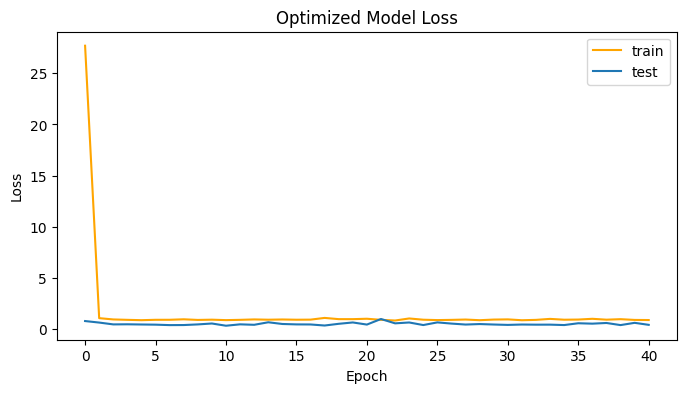

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
#Se realiza prediccion
results = best_model.predict(X_test)
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

9/9 [==============================] - 0s 2ms/step


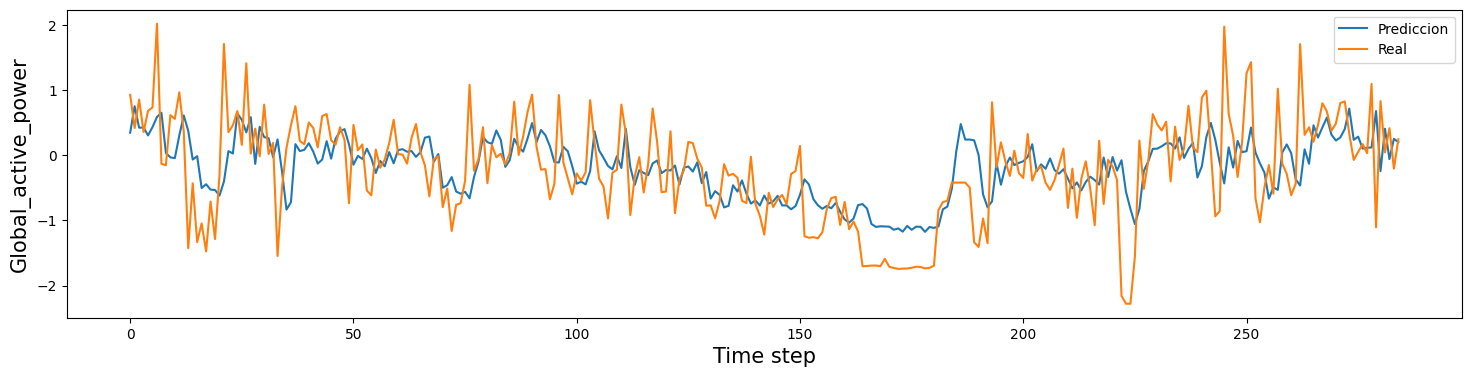

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [ ]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[0])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3961445689201355
RMSE: 0.6294001340866089
MAE: 0.4697885513305664
MAPE: 162.19737243652344


#4. Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "CNN_CE" + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])+"_"+str(result['params']['kernel_size'])+"_"+str(result['params']['filters'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [ ]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [ ]:
#Se muestran los mejores 5 resultados
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

In [ ]:
# Exportar el DataFrame como CSV
# Exportar el DataFrame como CSV
folder_path = '/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_csv'
csv_filename = 'results_CNN_CE'
csv_path = os.path.join(folder_path, csv_filename)
results_csv.to_csv(csv_path, index=False)
results_csv.to_csv('results_CNN_CE.csv')

Se guarda cada modelo keras en un objeto Json

In [ ]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Resultados_Modelos/results_CNN'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana
for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "CNN_CE" + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])+"_"+str(result['params']['kernel_size'])+"_"+str(result['params']['filters'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1